# Import useful packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#import utilsPolytech
from utilsPolytech import resampleSensors

# Import data

In [72]:
raw_data = pd.read_csv("extract.txt", sep=";")

# Detect outliersset_index

In [73]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '16'

outlier_temp = np.where((raw_data['temperature'] >= (60)) ) # 60°C
outlier_humidity = np.where(raw_data['humidity'] >= (100)) # 100 %
outlier_tvoc = np.where(raw_data['tvoc'] >= (10000)) # 10 000 ppb
outlier_light = np.where(raw_data['light'] >= (100000)) # 10 000
outlier_sound = np.where(raw_data['sound'] >= (5000)) # 1 000
outlier_co2 = np.where(raw_data['co2'] >= (65535)) # 

outliers = np.unique(np.concatenate((outlier_temp[0],outlier_humidity[0],outlier_tvoc[0],
                                    outlier_light[0],outlier_sound[0],outlier_co2[0]),0))

In [78]:
filt_df= raw_data.copy()
low = .05
high = .95
quant_df = filt_df.quantile([low, high])
print(quant_df)


            id  sensor     co2    tvoc  temperature  humidity  light   sound
0.05   16103.4   100.0   399.0     7.0        23.27     21.91    0.0     9.0
0.95  329870.6   112.0  1286.0  2357.0        27.14     36.89  721.0  1011.0


C:\Users\ahmed\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tvoc'>

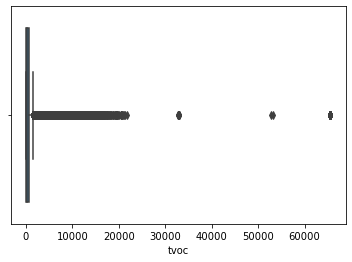

In [83]:
sns.boxplot(raw_data['tvoc'])

In [82]:
raw_data.max()

id                          362981
date           28/02/2022 23:59:55
room                          S219
sensor                         113
co2                          65535
tvoc                         65535
temperature                 655.35
humidity                    655.35
light                        65535
sound                        65535
dtype: object

## deal with outliers?

In [18]:
raw_data.drop(outliers, inplace = True)
print(len(raw_data))


313122


In [29]:
raw_data.drop(['id'], axis=1).head()

date  room  sensor   co2  tvoc  temperature  humidity  \
0  21/03/2022 14:25:13  S219     107   507    67        24.57     31.46   
1  21/03/2022 14:25:03  S219     106   443    68        24.57     31.57   
2  21/03/2022 14:24:53  S219     105  1087   167        24.78     31.34   
3  21/03/2022 14:24:43  S219     104   620    51        24.87     31.33   
4  21/03/2022 14:23:43  S219     107   506    52        24.55     31.50   

   light  sound  
0    548    511  
1    427    507  
2    494    511  
3    623    512  
4    552    510

# Separate sensors

In [30]:
# Number of sensors
nb_sensors = len(pd.unique(raw_data['sensor'])) 
sensors_list = raw_data.sensor.unique()
print("We have ",nb_sensors," sensors. Their Id are ", [i_sensor for i,i_sensor in enumerate(sensors_list)])

We have  14  sensors. Their Id are  [107, 106, 105, 104, 110, 109, 108, 103, 102, 101, 100, 112, 111, 113]


In [53]:
# Separate each sensor and Save all sensors in dictionary
listDataSensors={}
for i,i_sensor in enumerate(sensors_list):
    globals()['sensor_%s' % i_sensor] = raw_data.loc[raw_data["sensor"]==i_sensor]    
    globals()['sensor_%s' % i_sensor] = globals()['sensor_%s' % i_sensor].set_index('date')
    globals()['sensor_%s' % i_sensor].drop(["id","sensor","room"],axis=1, inplace = True)
    globals()['sensor_%s' % i_sensor].columns = globals()['sensor_%s' % i_sensor].columns+'_'+str(i_sensor)    
    globals()['sensor_%s' % i_sensor].index = pd.to_datetime(globals()['sensor_%s' % i_sensor].index,dayfirst=True)
    globals()['sensor_%s' % i_sensor].sort_index(inplace=True) # index sorted
    print('sensor_{}'.format(i_sensor))
    dictTemp= {'sensor_%s' % i_sensor: globals()['sensor_%s' % i_sensor] }
    listDataSensors.update(dictTemp)
# Save all sensors in dictionary
np.save('Sensors219.npy', listDataSensors)  


sensor_107
sensor_106
sensor_105
sensor_104
sensor_110
sensor_109
sensor_108
sensor_103
sensor_102
sensor_101
sensor_100
sensor_112
sensor_111
sensor_113


## Data fusion 

In [113]:
## fusion des données par master and all
dfs =[dic['sensor_100'],dic['sensor_101'],dic['sensor_102'], dic['sensor_103']]
df1 = dfs[0].join(dfs[1:])
dfs =[dic['sensor_104'],dic['sensor_105'],dic['sensor_106'], dic['sensor_107']]
df2 = dfs[0].join(dfs[1:])
dfs =[dic['sensor_108'],dic['sensor_109'],dic['sensor_110']]
df3 = dfs[0].join(dfs[1:])
dfs =[dic['sensor_111'],dic['sensor_112'],dic['sensor_113']]
df4 = dfs[0].join(dfs[1:])
dfs = [df1,df2,df3,df4]
df = dfs[0].join(dfs[1:])

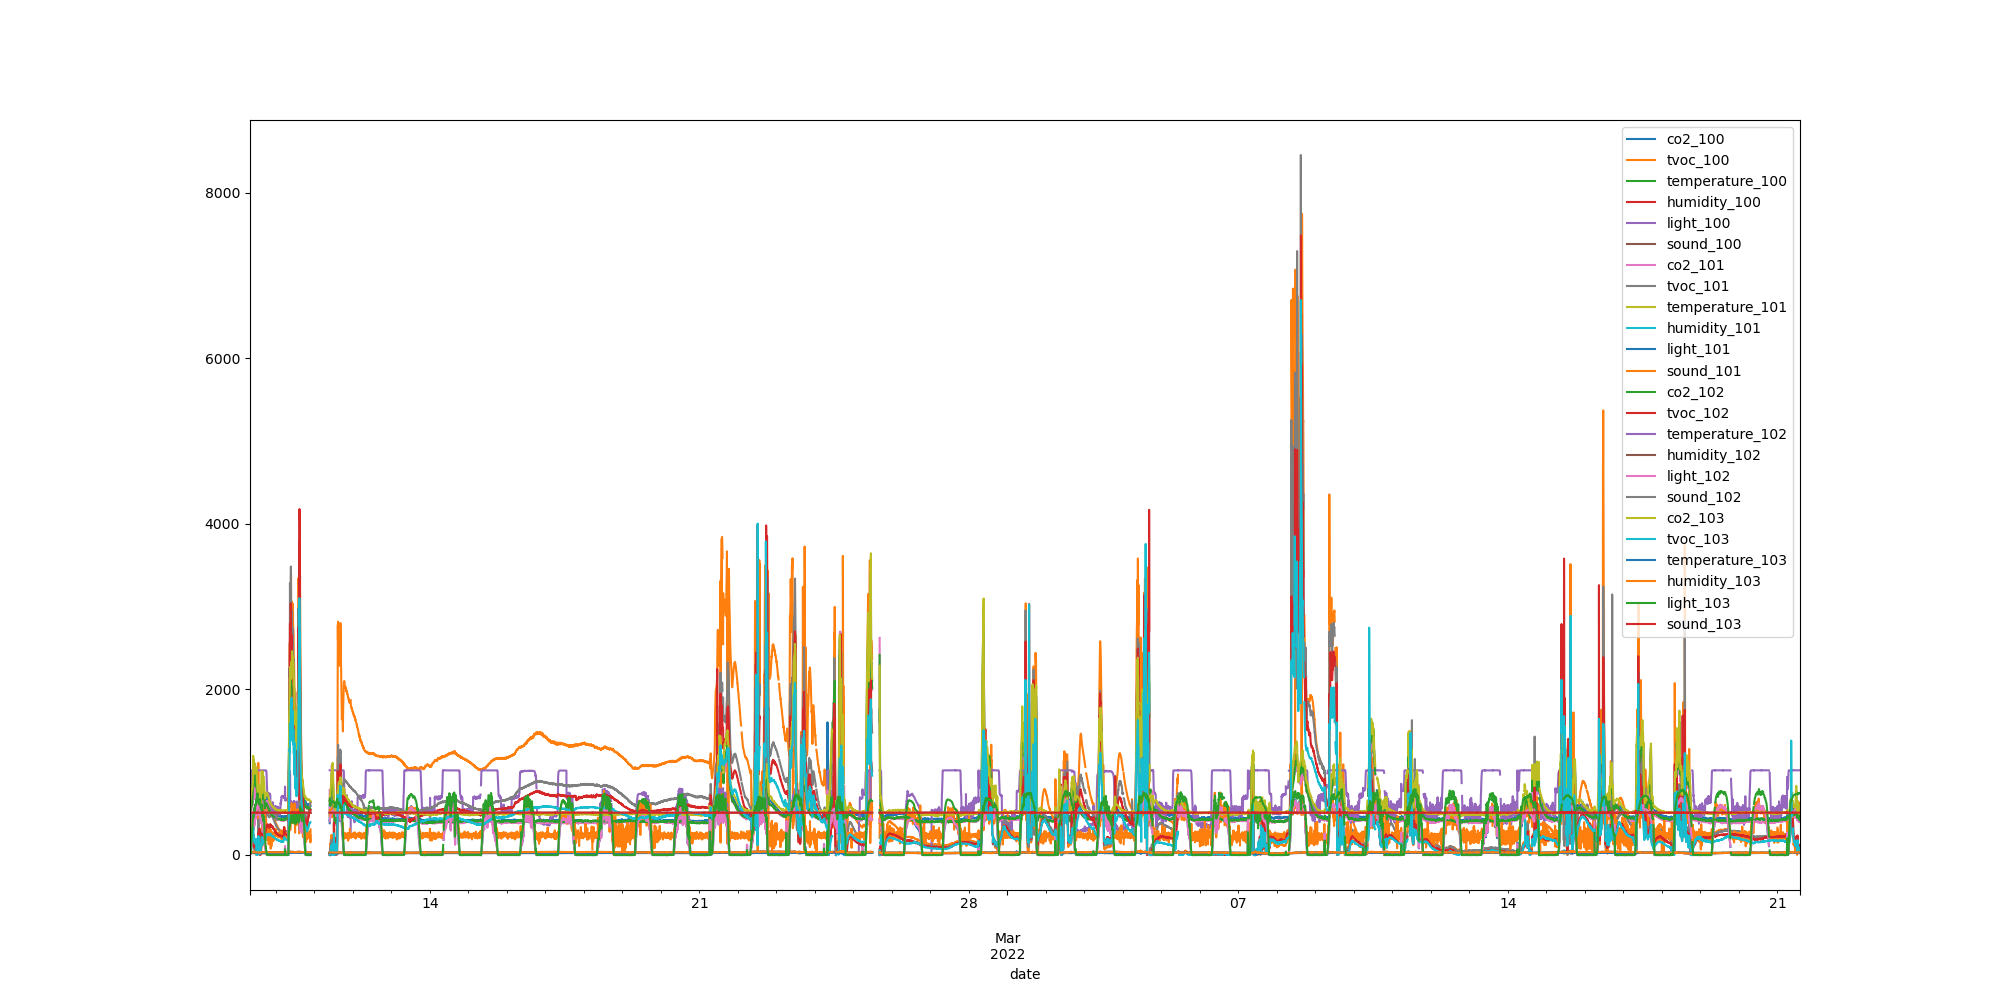

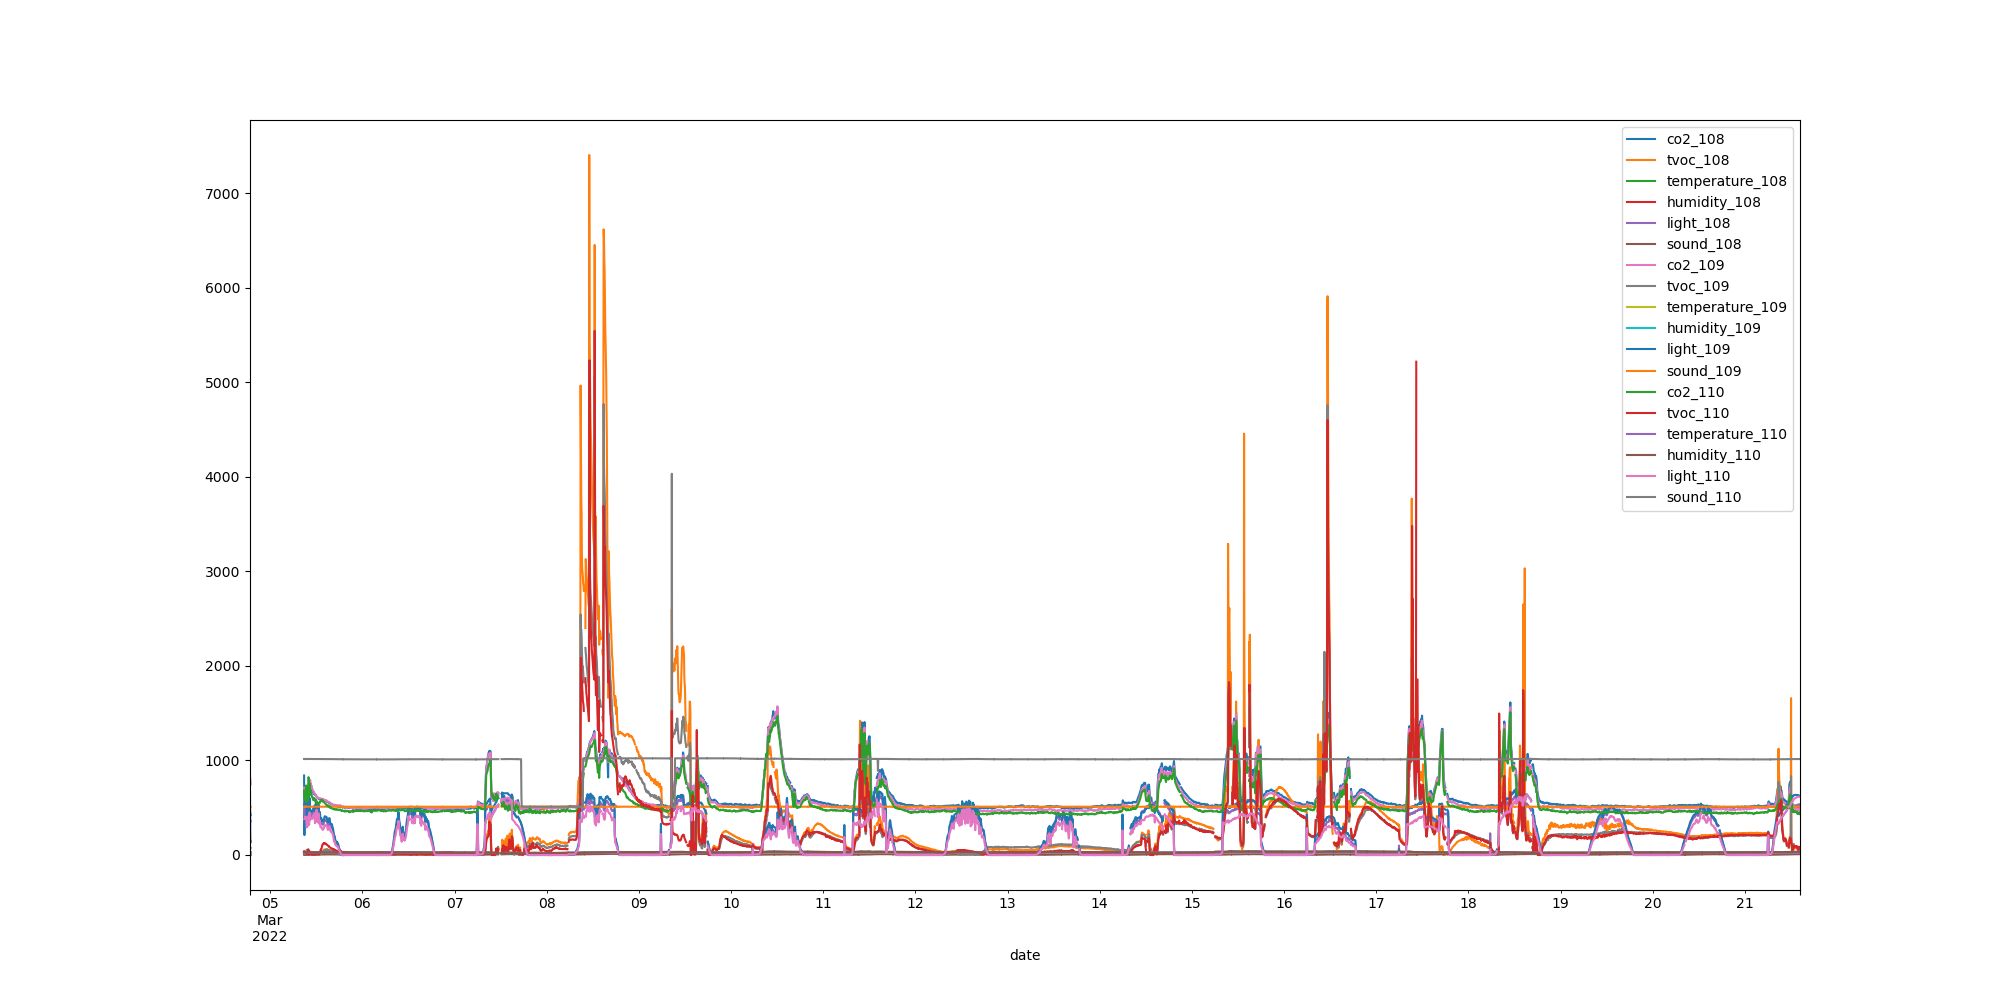

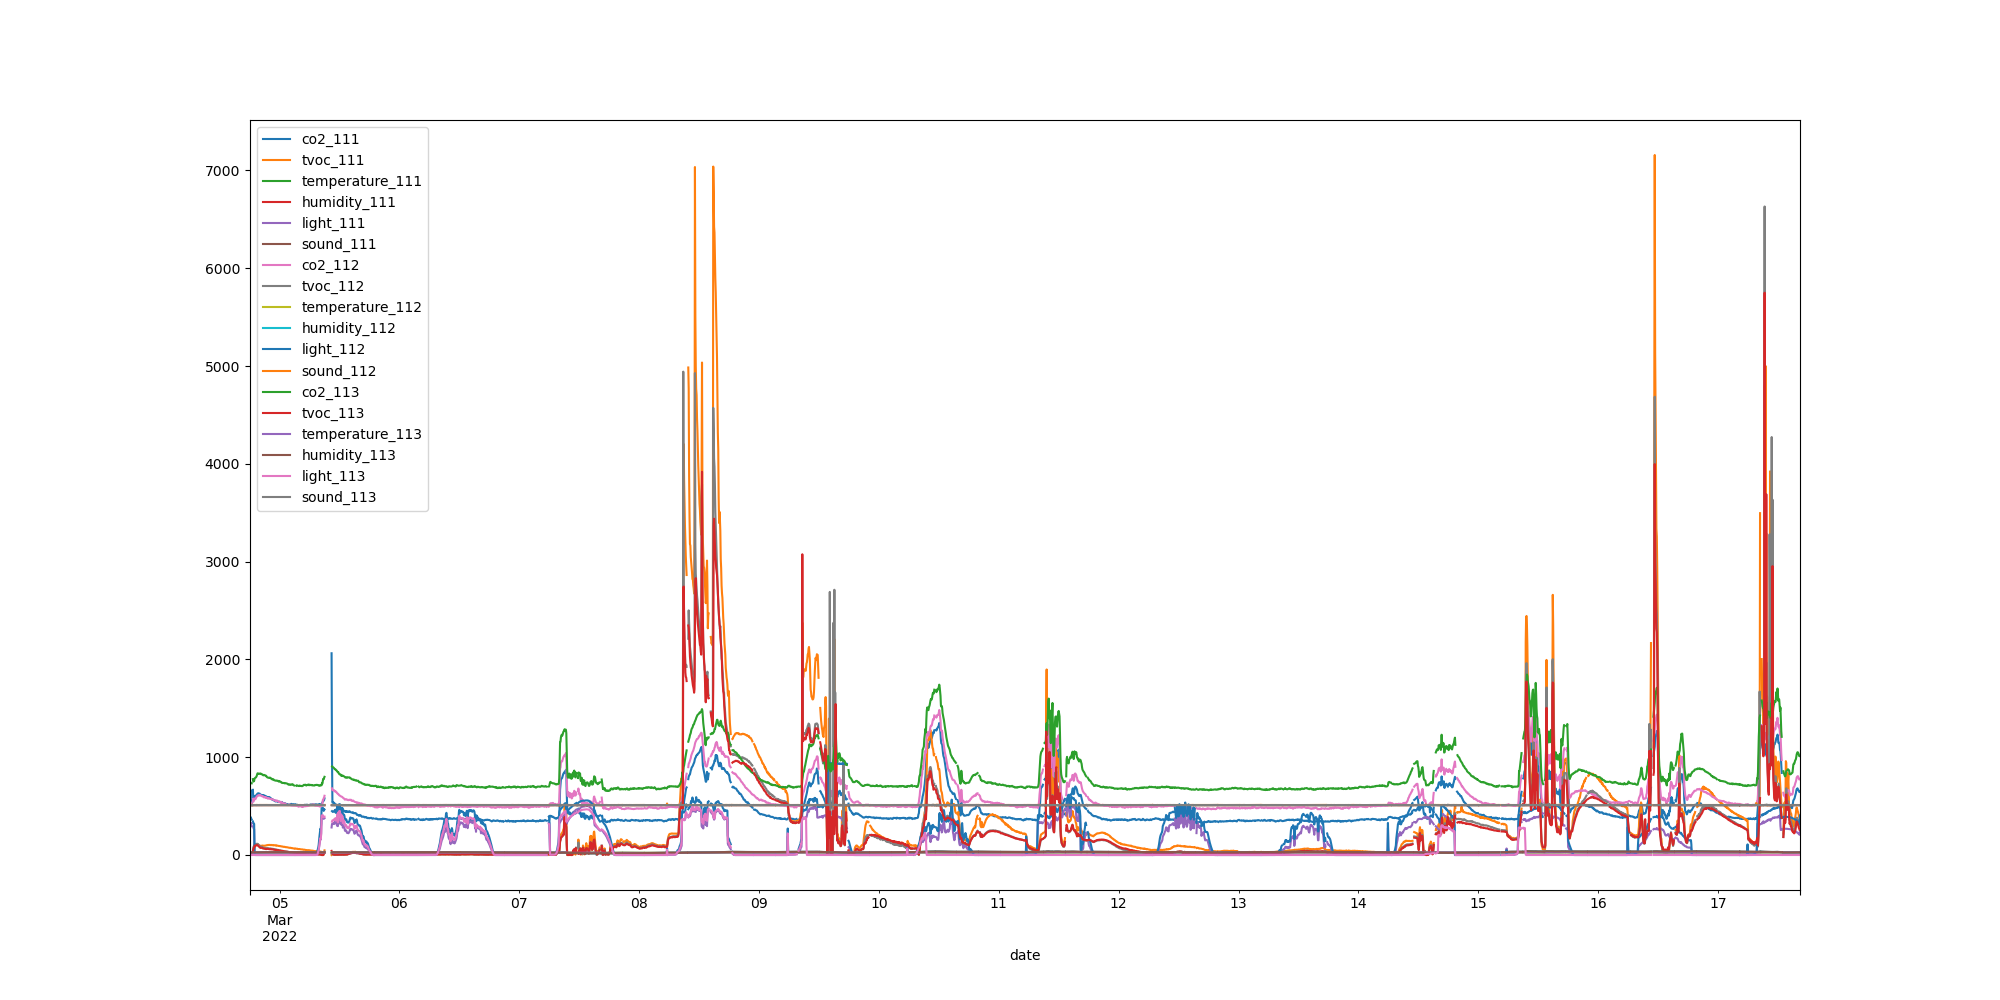

In [131]:
for df in dfs :    
    df.plot(figsize=(20, 10), subplots=False)

In [30]:
def resampleSensors(dict,period='5T'):
    for cle, valeur in dict.items():       
        sensortemp = valeur.resample(period).mean()
        dictTemp= {cle: sensortemp }
        dict.update(dictTemp) 
    return dict

In [6]:
# Load
read_dictionary = np.load('Sensors219.npy',allow_pickle='TRUE').item()
dictSensors = read_dictionary.copy()
dictSensors = resampleSensors(dictSensors,period='30T')

In [ ]:
dictSensors

In [ ]:
dic

In [33]:
for cle, valeur in dic.items():
    print(cle)
    

sensor_107
sensor_106
sensor_105
sensor_104
sensor_110
sensor_109
sensor_108
sensor_103
sensor_102
sensor_101
sensor_100
sensor_112
sensor_111
sensor_113


# Analyse measured data

In [13]:
corr = raw_data.corr()
corr

id    sensor       co2      tvoc  temperature  humidity  \
id           1.000000  0.324379  0.016087 -0.230451     0.316584 -0.186467   
sensor       0.324379  1.000000  0.056038 -0.136411     0.197886 -0.122700   
co2          0.016087  0.056038  1.000000  0.384276     0.427614  0.185503   
tvoc        -0.230451 -0.136411  0.384276  1.000000     0.088187  0.247642   
temperature  0.316584  0.197886  0.427614  0.088187     1.000000  0.187113   
humidity    -0.186467 -0.122700  0.185503  0.247642     0.187113  1.000000   
light       -0.025811 -0.295595  0.195979  0.153040     0.120714  0.015199   
sound        0.036051  0.175360  0.044872 -0.001005     0.063187  0.007550   

                light     sound  
id          -0.025811  0.036051  
sensor      -0.295595  0.175360  
co2          0.195979  0.044872  
tvoc         0.153040 -0.001005  
temperature  0.120714  0.063187  
humidity     0.015199  0.007550  
light        1.000000  0.064373  
sound        0.064373  1.000000

sns.pairplot(sensor_100.drop(["id","date","room","sensor"],axis=1), hue="co2")

<AxesSubplot:xlabel='sensor', ylabel='temperature'>

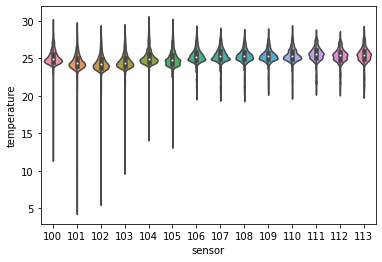

In [14]:
sns.violinplot(x="sensor", y="temperature", data=raw_data)

<AxesSubplot:xlabel='sensor', ylabel='co2'>

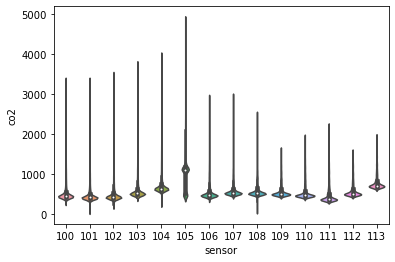

In [15]:
sns.violinplot(x="sensor", y="co2", data=raw_data)

<AxesSubplot:xlabel='sensor', ylabel='tvoc'>

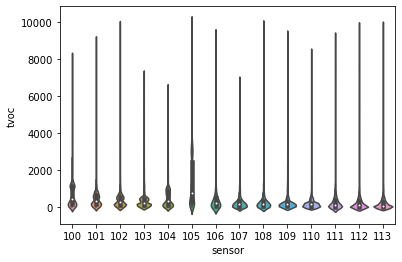

In [16]:
sns.violinplot(x="sensor", y="tvoc", data=raw_data)

<AxesSubplot:xlabel='sensor', ylabel='humidity'>

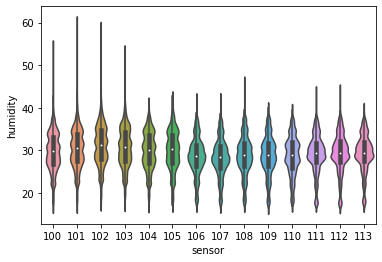

In [17]:
sns.violinplot(x="sensor", y="humidity", data=raw_data)

<AxesSubplot:xlabel='sensor', ylabel='light'>

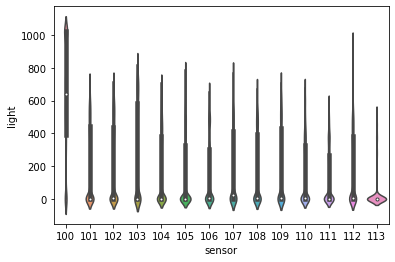

In [18]:
sns.violinplot(x="sensor", y="light", data=raw_data)

<AxesSubplot:xlabel='sensor', ylabel='sound'>

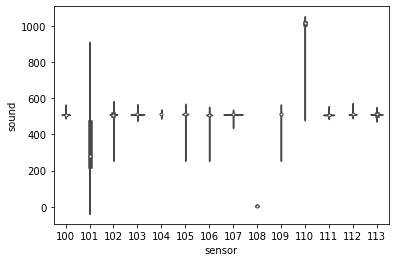

In [19]:
sns.violinplot(x="sensor", y="sound", data=raw_data)

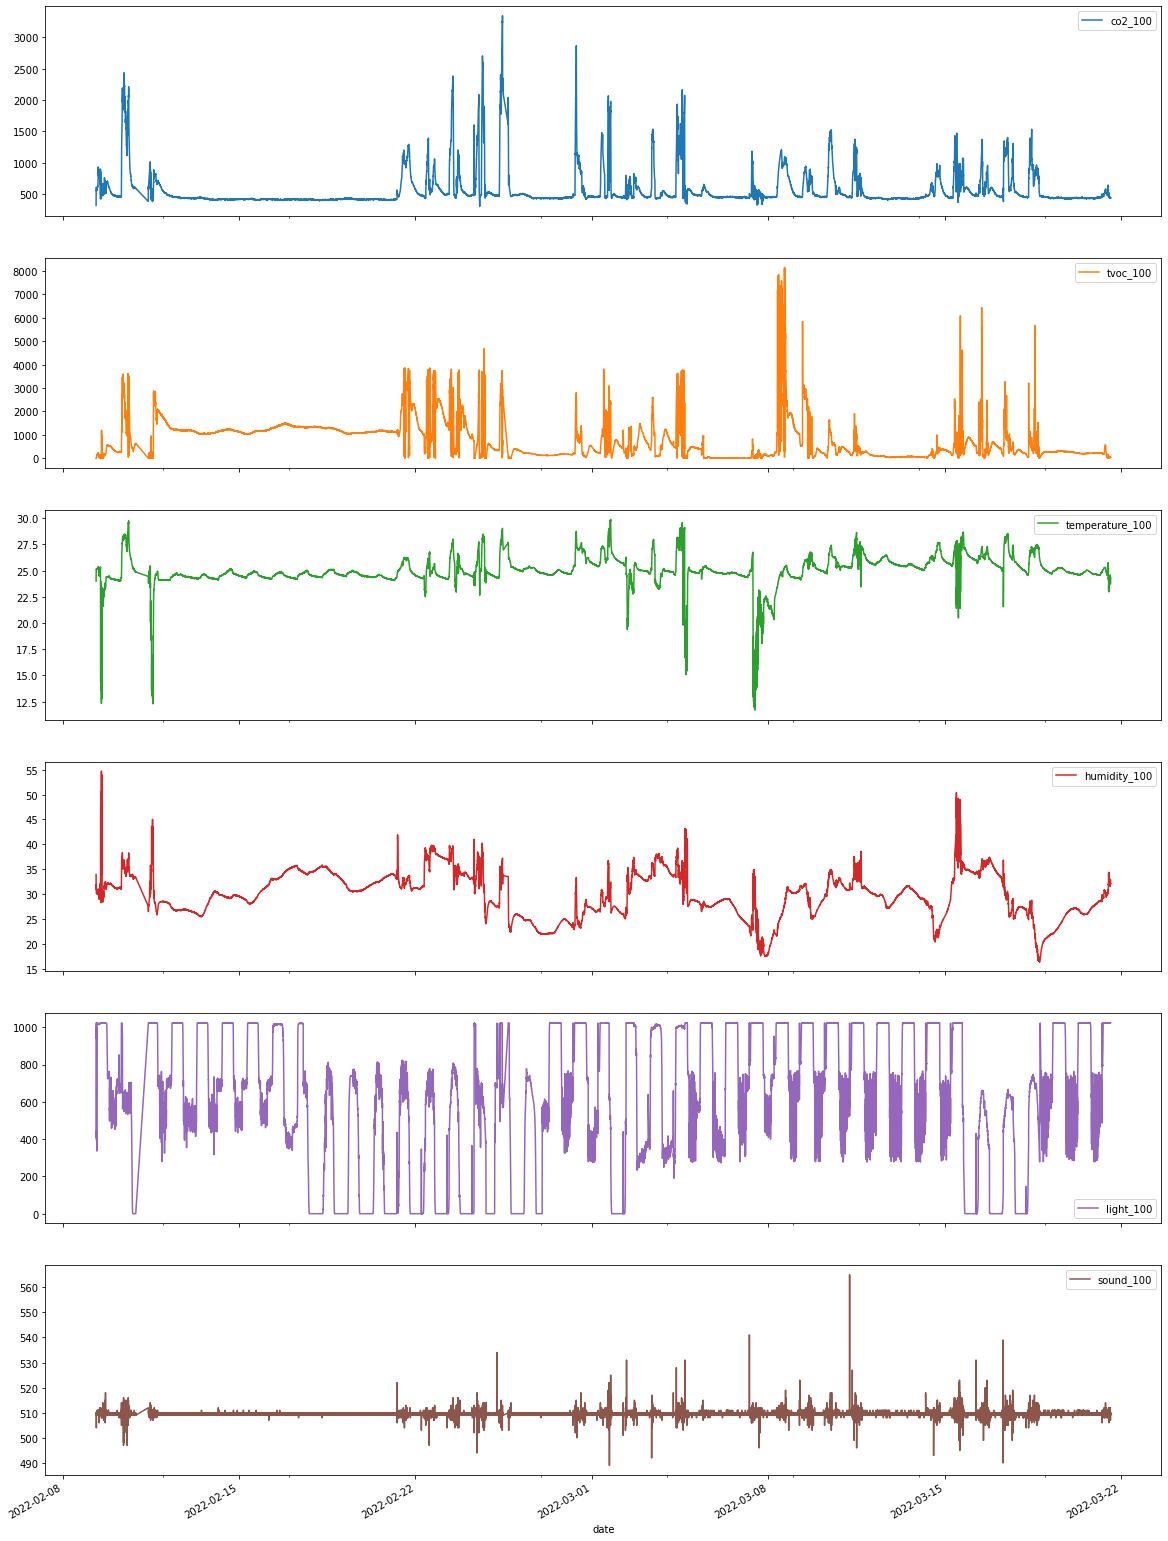

In [20]:
# for sensor 100
axs = sensor_100.plot(figsize=(20, 30), subplots=True)

Sensors to display :  [104 110 109 108 103 102 101 100 112 111 113]


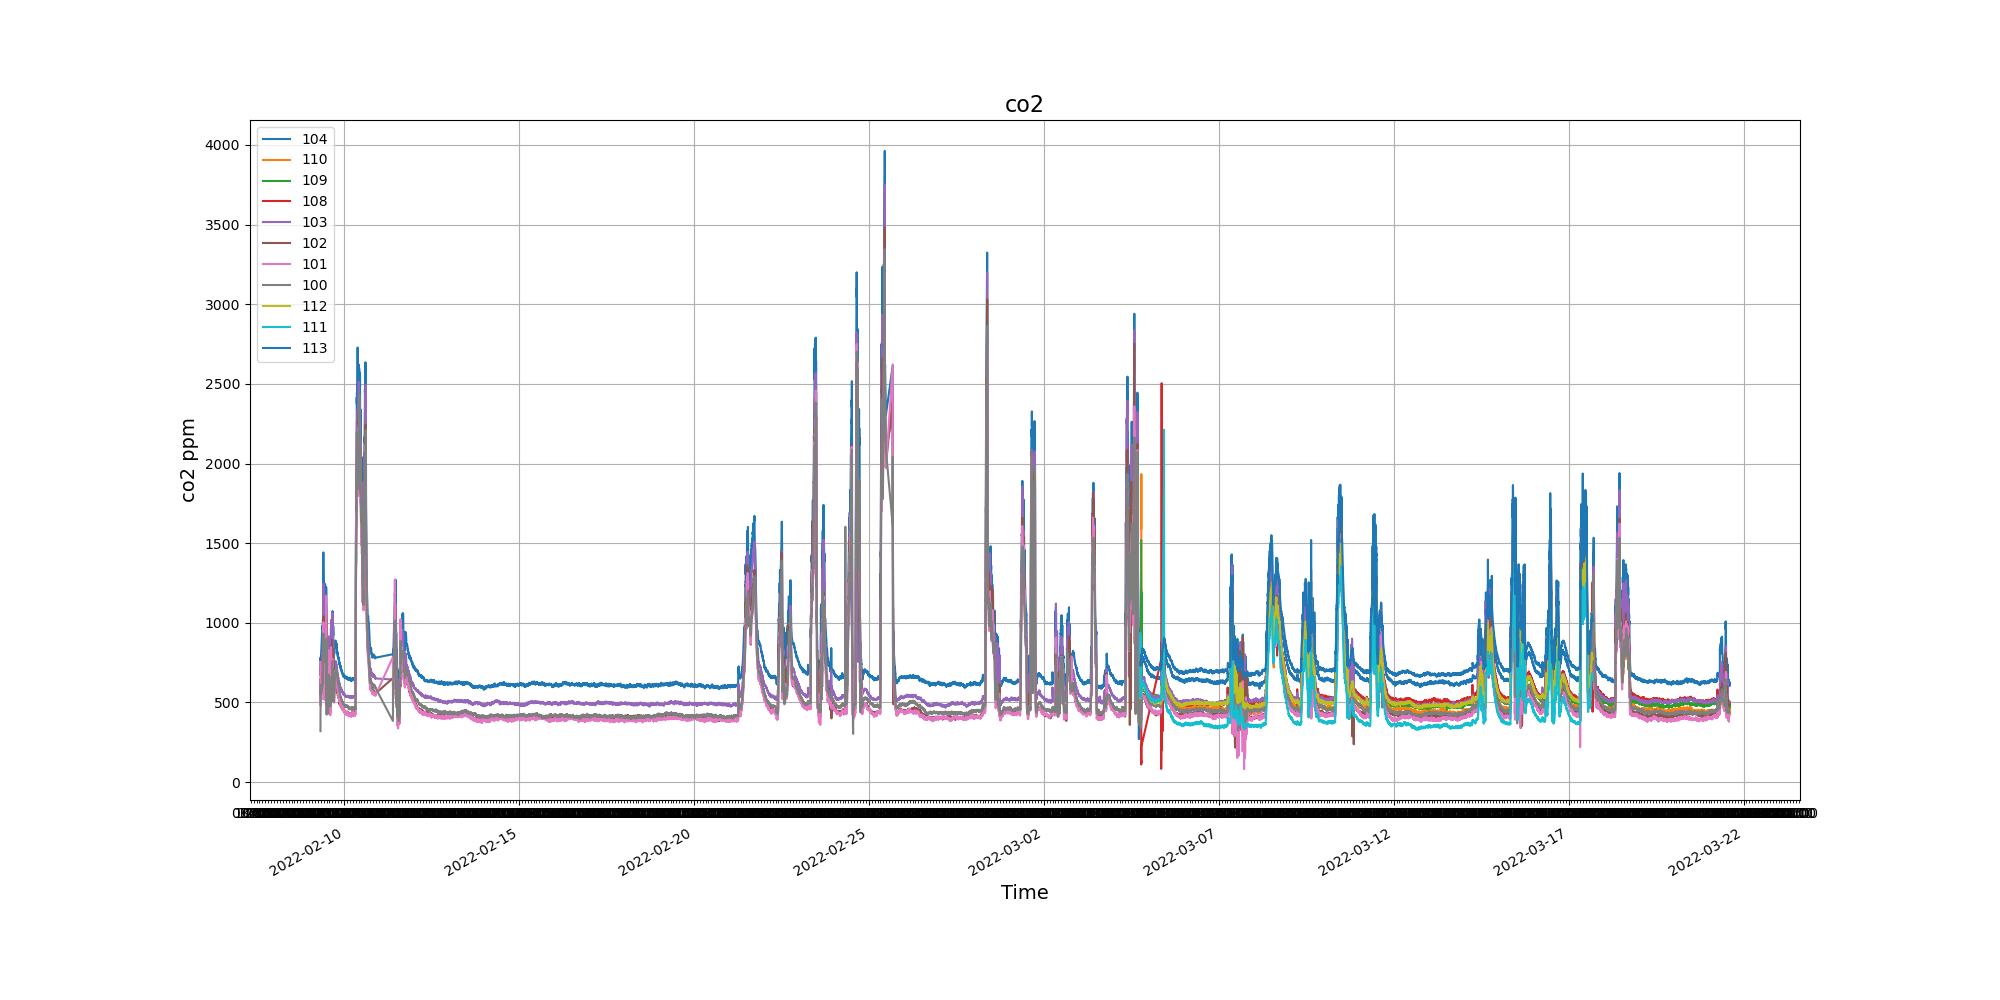

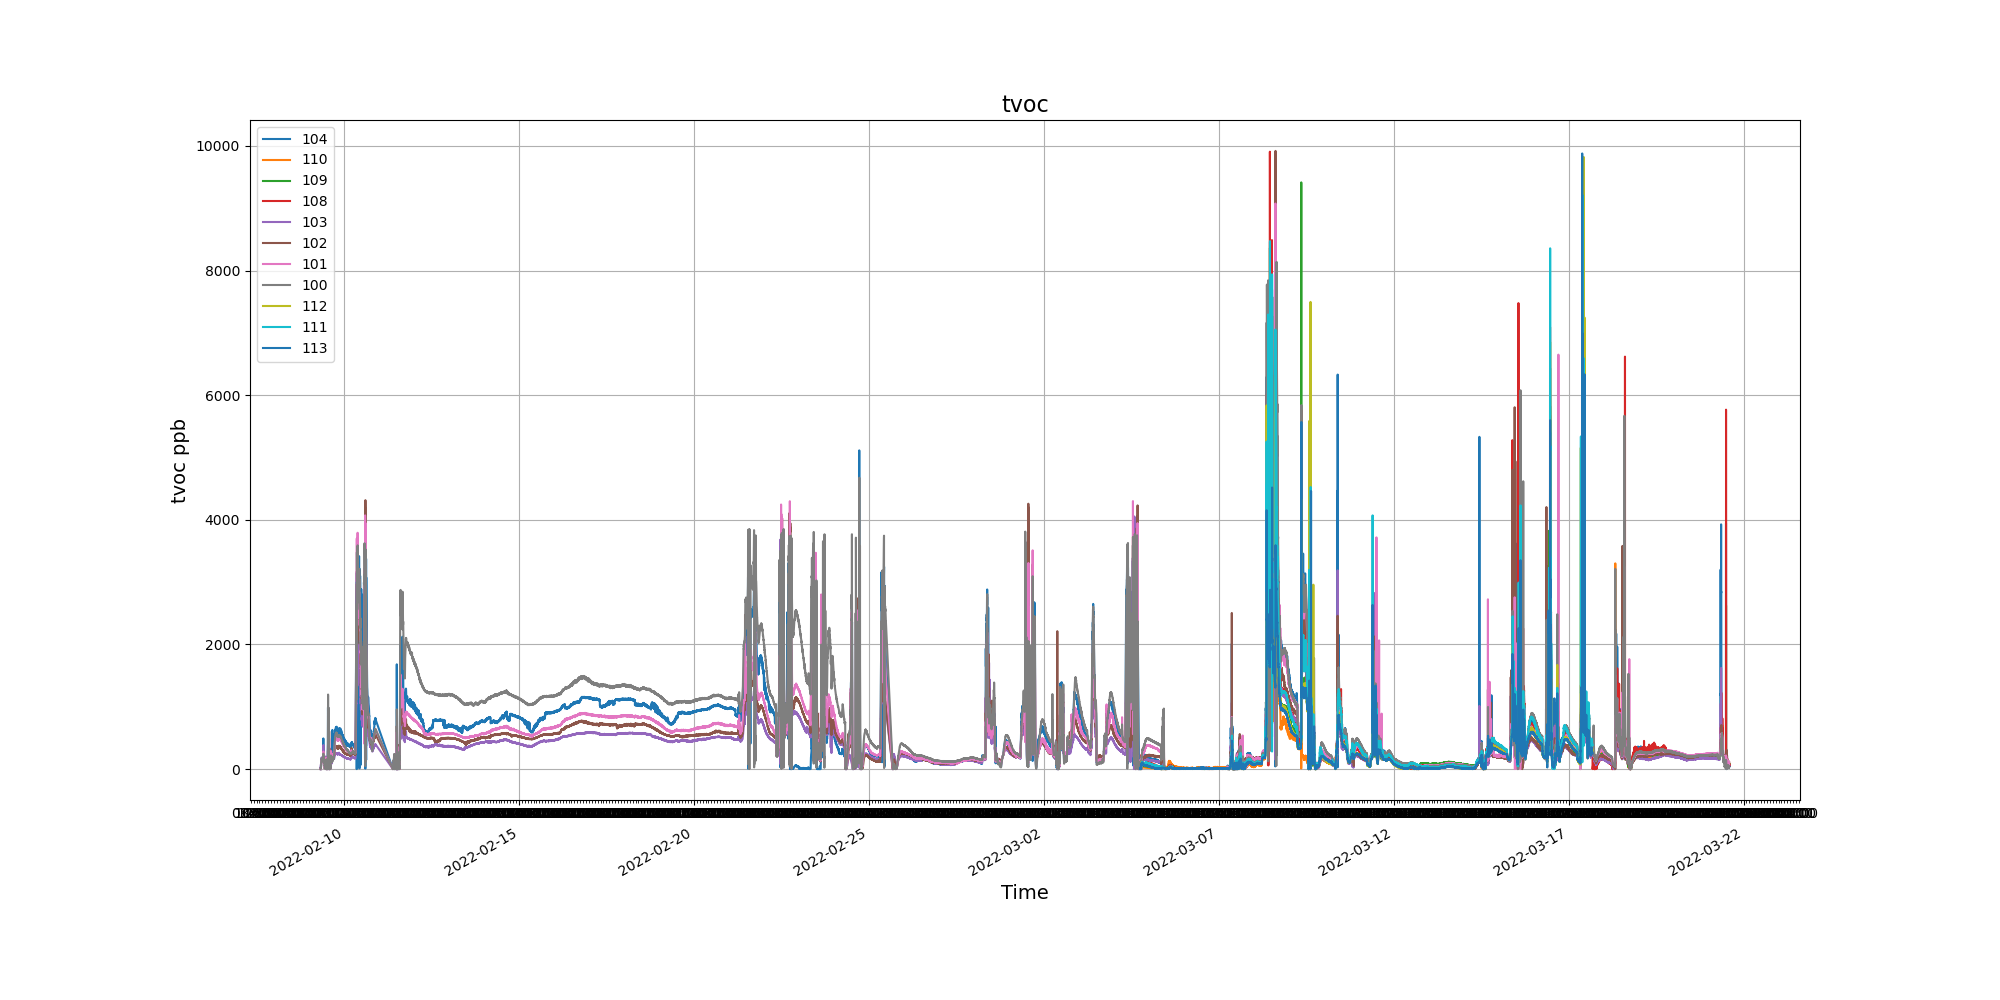

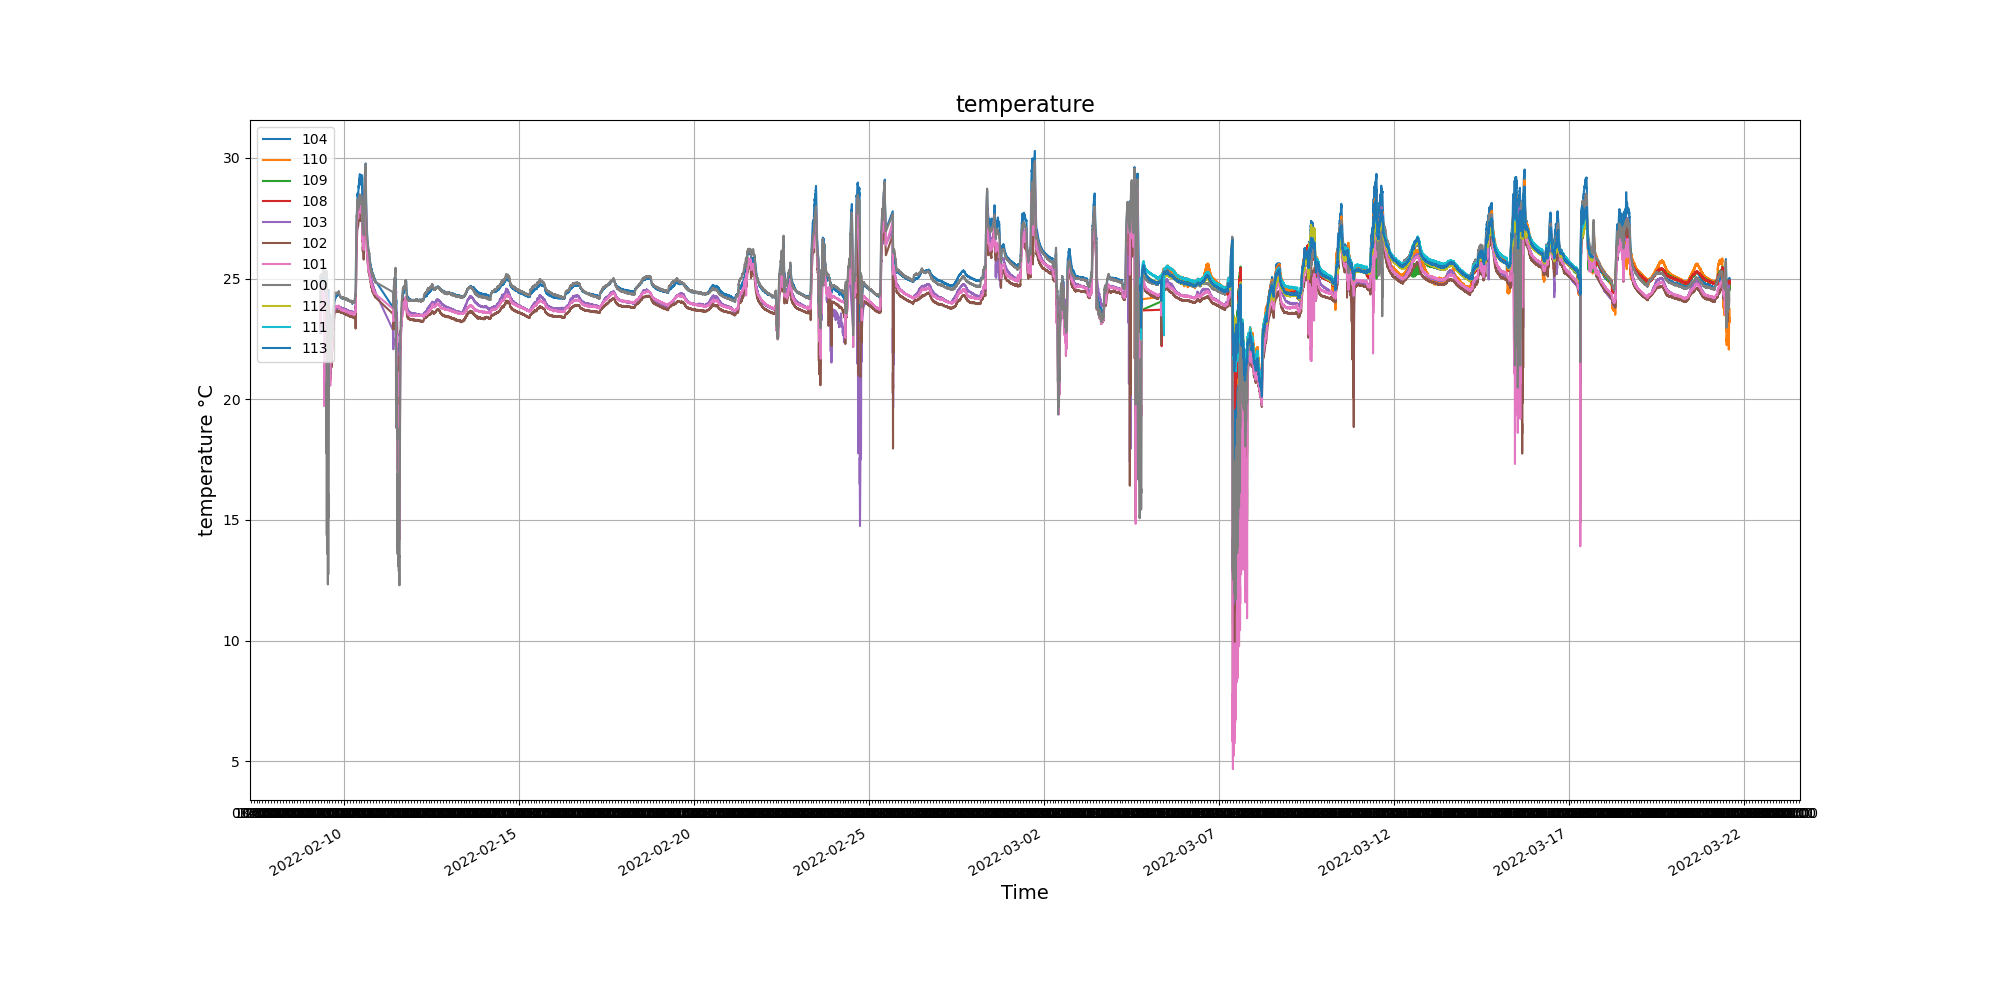

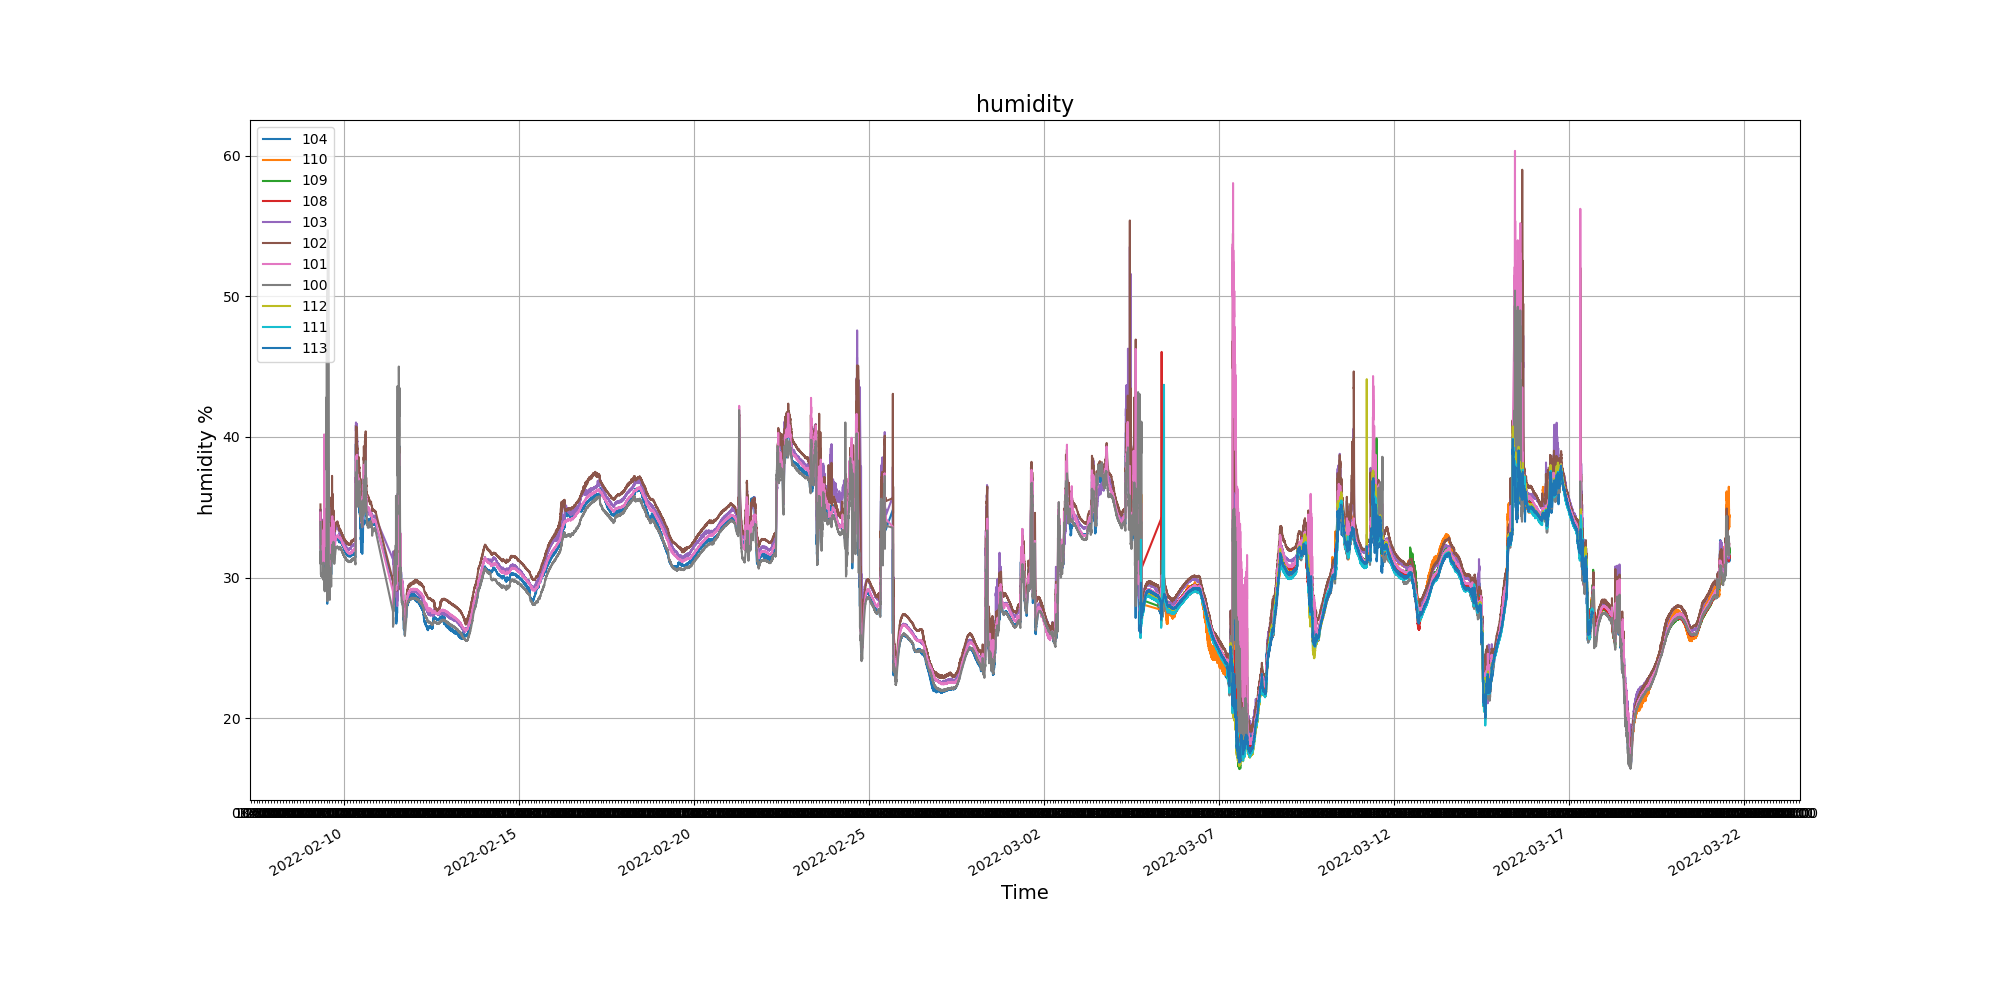

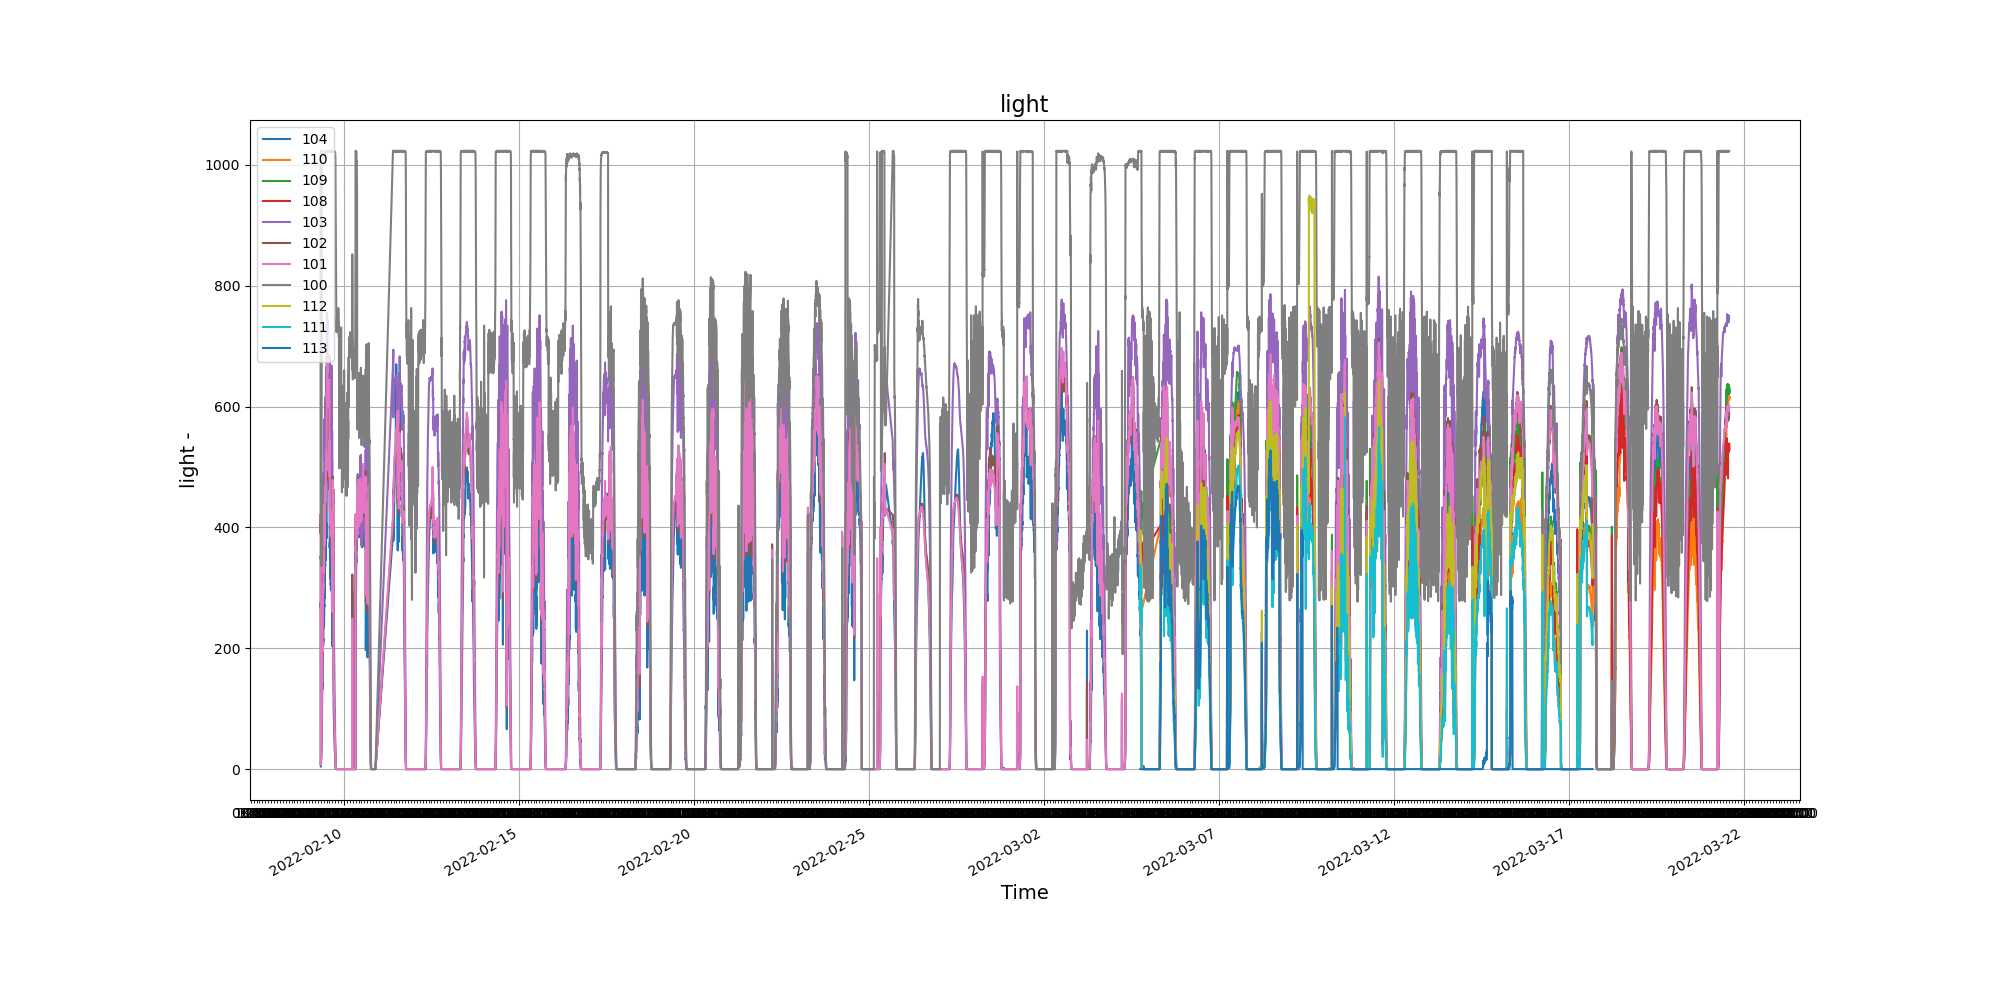

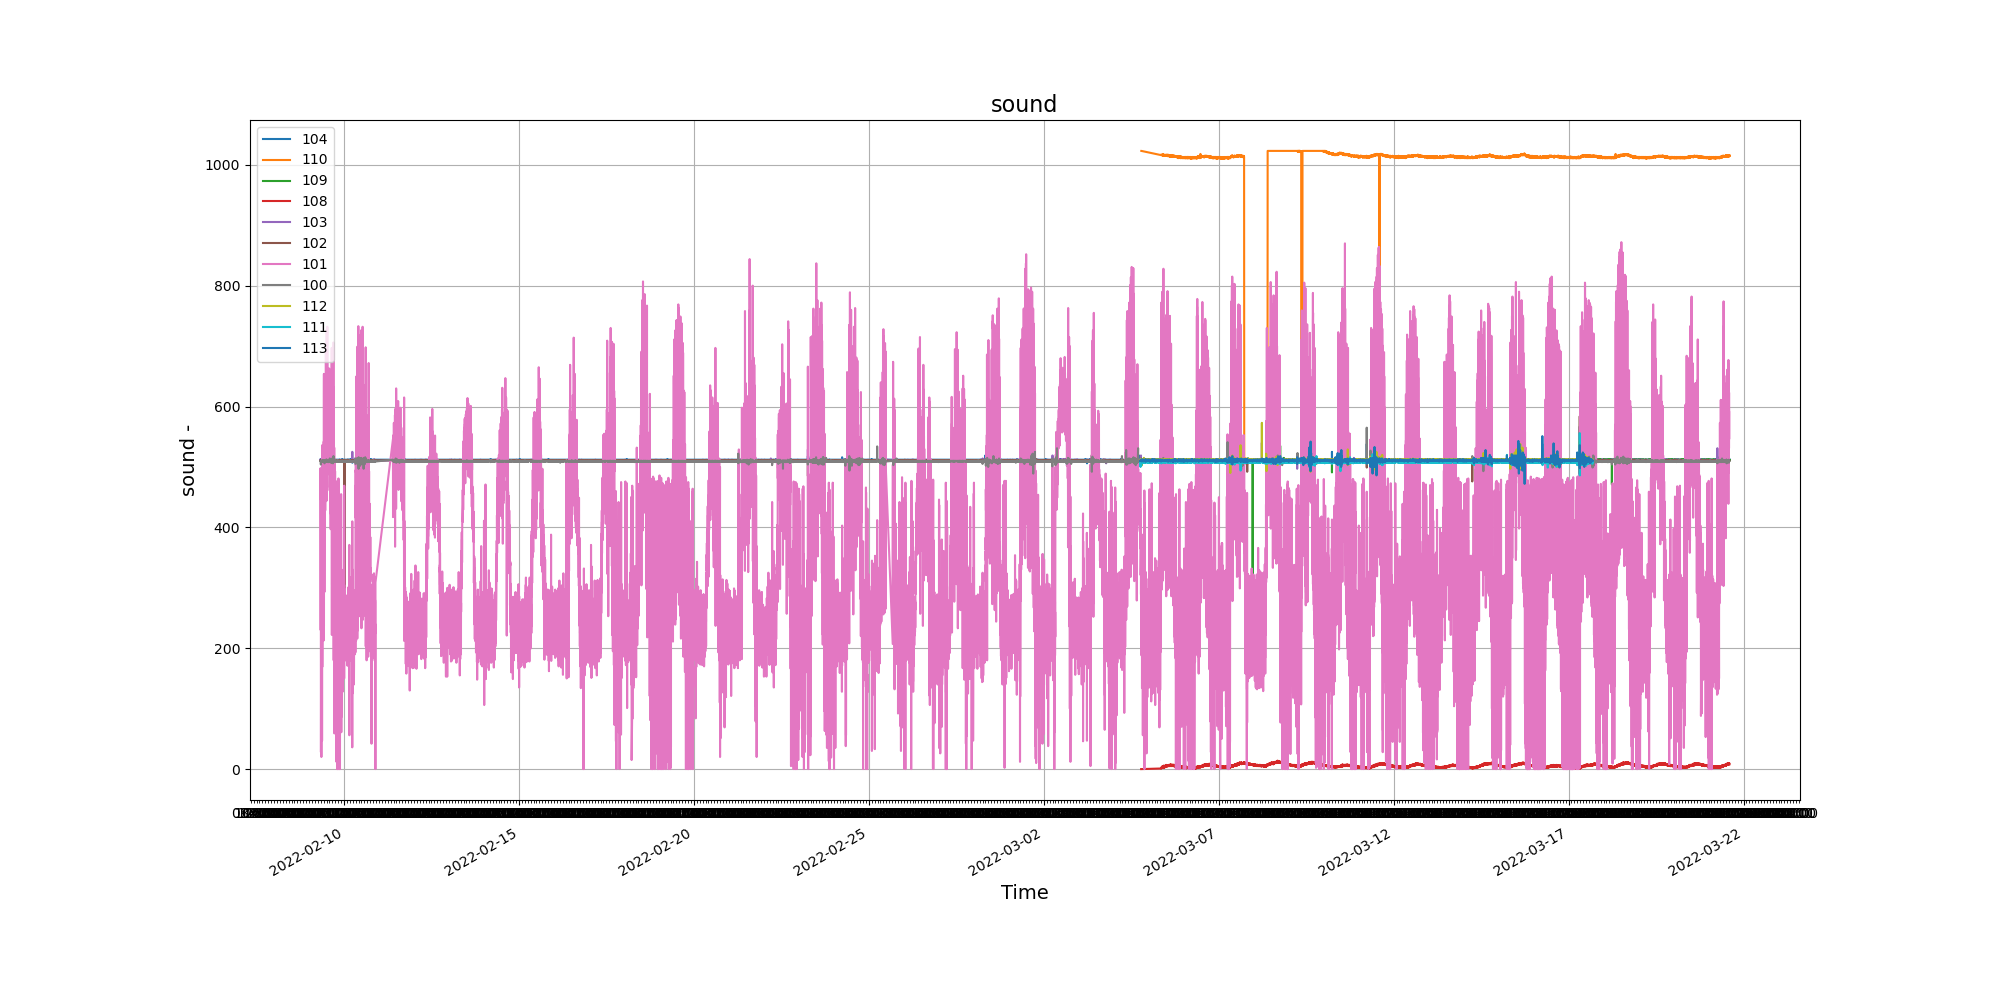

In [25]:
# Compare data from all sensors
import ipywidgets as widgets
%matplotlib widget

excluded_sensors = [105,106,107]
sensors_list_updated = np.delete(sensors_list, [np.where(sensors_list == i) for i in excluded_sensors])
print("Sensors to display : ",sensors_list_updated)

values = ["co2","tvoc","temperature","humidity" ,"light","sound"]
units  = ["ppm","ppb","°C","%","-","-"]

hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
days = mdates.DayLocator(interval=5)
d_fmt = mdates.DateFormatter('%Y-%m-%d')

for i,i_value in enumerate(values):
    fig, ax = plt.subplots(figsize=(20,10))
    
    for i_sensor in sensors_list_updated : 
        globals()['ax_%s' % i_sensor] = pd.Series(globals()['sensor_%s' % i_sensor][i_value+'_'+str(i_sensor)]).plot(grid=True, 
                                                                                                   label=str(i_sensor))
    
    plt.ylabel((i_value+" "+units[i]), fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.title(i_value, fontsize=16)    
    ax.xaxis.set_minor_locator(hours)
    ax.xaxis.set_minor_formatter(h_fmt)
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(d_fmt)
    ax.get_xaxis().set_tick_params(which='major', pad=15) #major locator under minor
    plt.legend(loc="upper left")

    #display plot
    plt.show()

IndexError: list index out of range

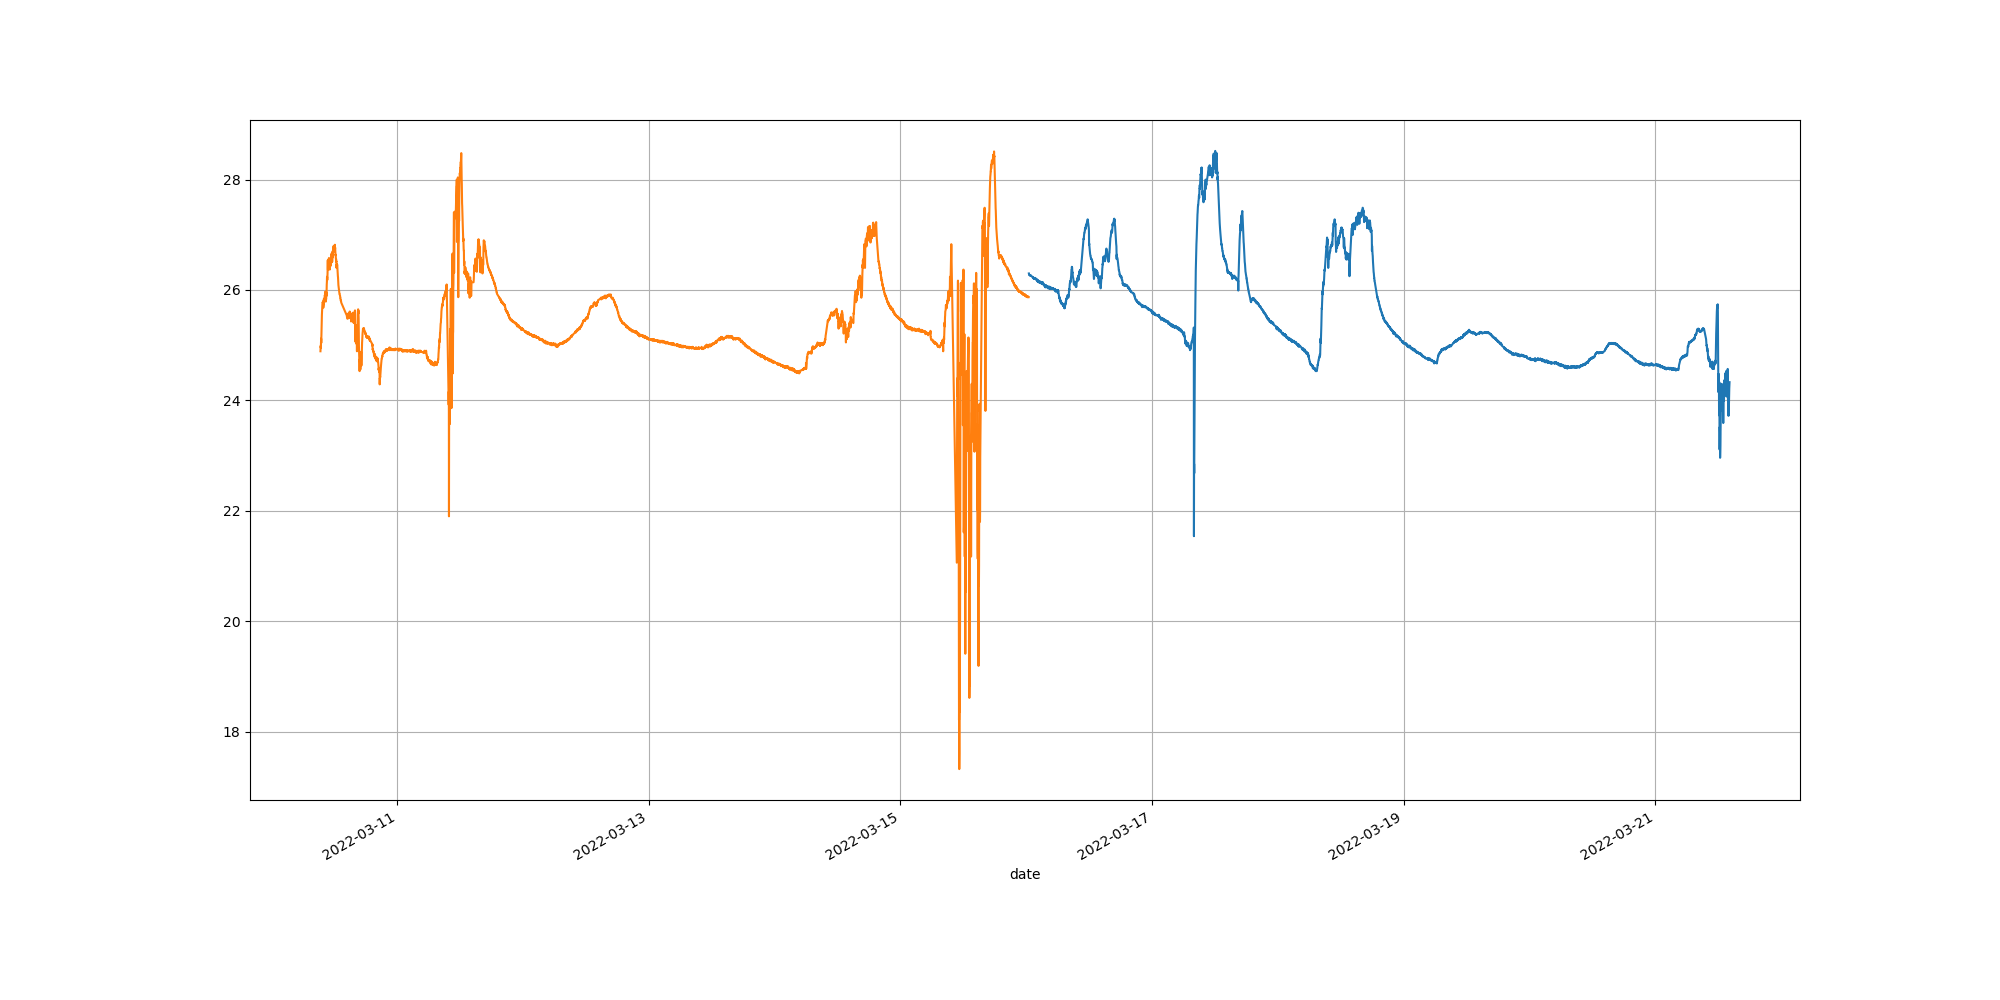

In [42]:
# Verif bonne prise en compte des dates
i_value = "temperature"
fig, ax = plt.subplots(figsize=(20,10))
df1 = pd.Series(sensor_100[i_value+'_100'])[0:5000]
df2 = pd.Series(sensor_101[i_value+'_101'])[5000:10000]

ax1 = df1.plot(grid=True, label='100')
ax2 = df2.plot(grid=True, label='101')

plt.ylabel((i_value+" "+units[i]), fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(i_value, fontsize=16)
    
ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_minor_formatter(h_fmt)
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(d_fmt)
ax.get_xaxis().set_tick_params(which='major', pad=15) #major locator under minor
plt.legend(loc="upper left")

plt.show()

In [332]:
print(sensor_100.shape, sensor_101.shape)

(32448, 9) (32399, 9)


In [333]:
sensor_103.id

date
2022-03-21 14:09:18    362801
2022-03-21 14:07:48    362797
2022-03-21 14:06:18    362793
2022-03-21 14:04:48    362789
2022-03-21 14:03:18    362785
                        ...  
2022-02-09 08:02:02        28
2022-02-09 07:56:59        22
2022-02-09 07:55:09        16
2022-02-09 07:53:19        10
2022-02-09 07:51:29         4
Name: id, Length: 32349, dtype: int64

In [51]:
# fusion de des capteurs
sensor_100.sort_index(inplace=True)
sensor_101.sort_index(inplace=True)
sensor_101_ = sensor_100.copy()
sensor_100_ = sensor_100.copy()
print("before", sensor_100_.shape,sensor_101_.shape, sensor_100_.co2_100.isnull().sum())
sensor_100_ = sensor_100_.resample('5T').mean()
sensor_101_ = sensor_101_.resample('5T').mean()
print("After", sensor_100_.shape,sensor_101.shape, sensor_100_.co2_100.isnull().sum())
df_inner = sensor_100_.merge(sensor_101_, how='left', left_index=True, right_index=True)
df_inner.shape

before (32448, 6) (32448, 6) 0
After (11596, 6) (32399, 6) 607


(11596, 12)

In [48]:
sensor_100_

<ipython-input-362-e3312272993a>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  sensor_100_['2022-03-02'].co2.plot()


<AxesSubplot:xlabel='date'>

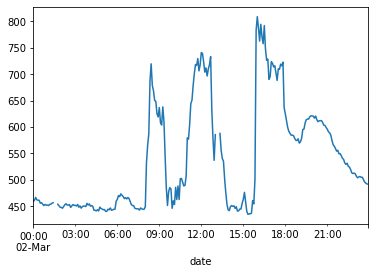

In [362]:
sensor_100_['2022-03-02'].co2.plot()

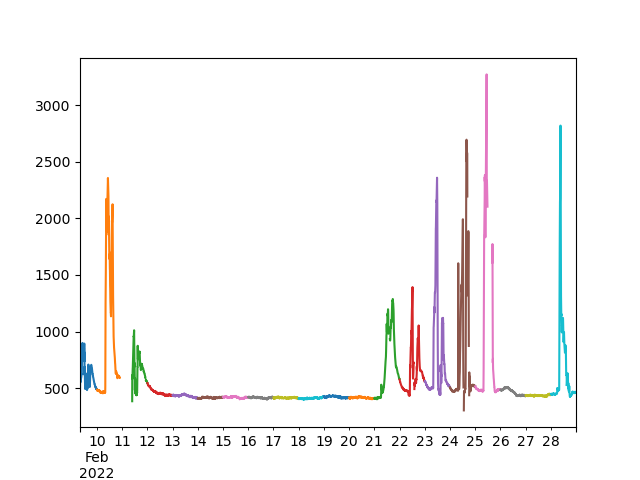

In [443]:
import ipywidgets as widgets
%matplotlib widget
sensor_100_.loc['2022-02', 'co2'].resample('D').plot()
plt.show()

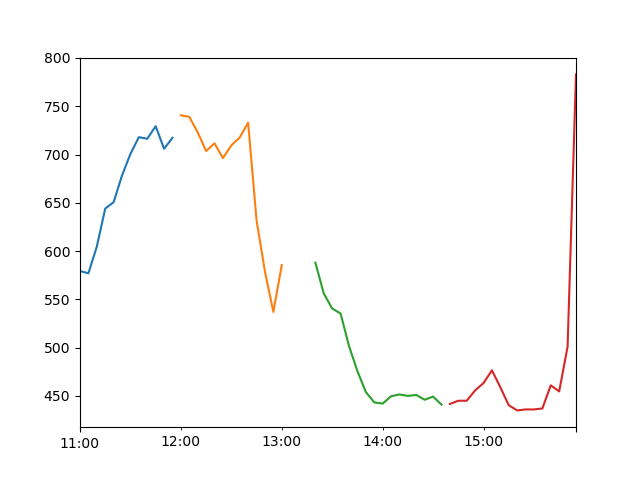

In [440]:
import matplotlib.pyplot as plt

import ipywidgets as widgets
%matplotlib widget

sensor_100_.loc['2022-03-02 11':'2022-03-02 15', 'co2'].resample('1.33H').plot()
plt.show()

In [359]:
sensor_100.sort_index(inplace=True)
y=sensor_100.index
ydif=y[1:]-y[:-1]
ydif.min()

Timedelta('0 days 00:00:27')

In [363]:
ydif.max()
hawks = sensor_100_

<Figure size 720x432 with 0 Axes>

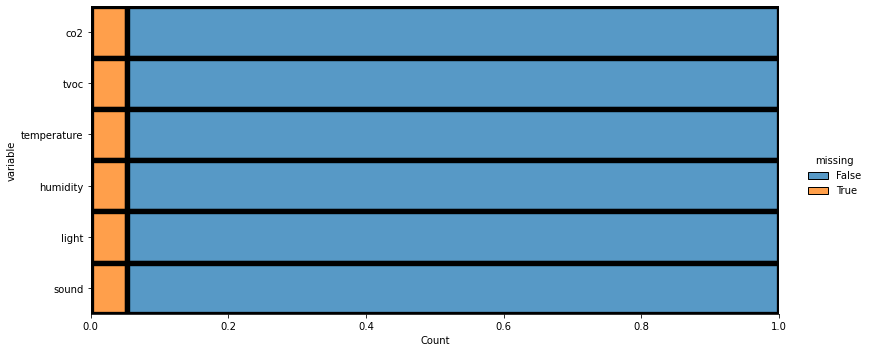

In [370]:
plt.figure(figsize=(10,6))
sns.displot(
    data=hawks.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=2.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [376]:

ydif=y[1:]-y[:-1]
ydif.min()

Timedelta('0 days 00:05:00')

In [377]:
ydif.max()

Timedelta('0 days 00:05:00')

In [ ]:
for i in range(1150):
    print(sensor_100_[['co2', 'temperature','humidity']][i*10:(i+1)*10])

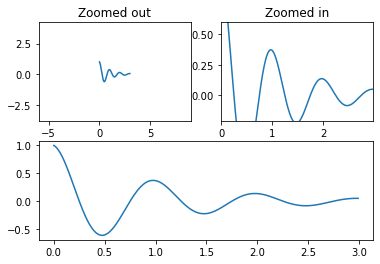

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.01)

ax1 = plt.subplot(212)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1))

ax2 = plt.subplot(221)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t1, f(t1))
ax2.set_title('Zoomed out')

ax3 = plt.subplot(222)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1))
ax3.set_title('Zoomed in')

plt.show()

In [44]:
# fusion de des capteurs
sensor_100.sort_index(inplace=True)
sensor_101.sort_index(inplace=True)
sensor_101_ = sensor_101.drop(['id','room','sensor'],axis=1)
sensor_100_ = sensor_100.drop(['id','room','sensor'],axis=1)
print("before", sensor_100_.shape,sensor_101_.shape, sensor_100_.co2.isnull().sum())
sensor_100_ = sensor_100_.resample('5T').mean()
sensor_101_ = sensor_101_.resample('5T').mean()
print("After", sensor_100_.shape,sensor_101.shape, sensor_100_.co2.isnull().sum())
df_inner = sensor_100_.merge(sensor_101_, how='left', left_index=True, right_index=True)
df_inner.shape

NameError: name 'sensor_100_' is not defined

In [101]:
# Importing
import sklearn

import pandas as pd
 
# Load the dataset

bos_hou = raw_data.copy()

 
# Create the dataframe
column_name = bos_hou.columns
df_boston = bos_hou
df_boston.columns = column_name
print(df_boston.head())
 
''' Detection '''
# IQR
Q1 = np.percentile(df_boston['co2'], 5,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_boston['co2'], 95,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df_boston.shape)
 
# Upper bound
upper = np.where(df_boston['co2'] >= (Q3+5*IQR))
# Lower bound
lower = np.where(df_boston['co2'] <= (Q1-2*IQR))
 
''' Removing the Outliers '''
df_boston.drop(upper[0], inplace = True)
df_boston.drop(lower[0], inplace = True)
 
print("New Shape: ", df_boston.shape)

       id                 date  room  sensor   co2  tvoc  temperature  \
0  362981  21/03/2022 14:25:13  S219     107   507    67        24.57   
1  362980  21/03/2022 14:25:03  S219     106   443    68        24.57   
2  362979  21/03/2022 14:24:53  S219     105  1087   167        24.78   
3  362978  21/03/2022 14:24:43  S219     104   620    51        24.87   
4  362977  21/03/2022 14:23:43  S219     107   506    52        24.55   

   humidity  light  sound  
0     31.46    548    511  
1     31.57    427    507  
2     31.34    494    511  
3     31.33    623    512  
4     31.50    552    510  
Old Shape:  (313809, 10)
New Shape:  (313728, 10)


In [102]:
df_boston.max()

id                          362981
date           28/02/2022 23:59:55
room                          S219
sensor                         113
co2                           4834
tvoc                         65535
temperature                 655.35
humidity                    655.35
light                        65535
sound                        65535
dtype: object

In [85]:
df_boston

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       17.8  392.83   4.03  
3       18.7  394.63   2.94  
4       18.7  396.90   5.33  
..       ...     ...    ...  
501     21.0  391.99   9.67  
502     21.0  396.90   9.08  
503     21.0  396.90   5.64  
504     21.0  393.45   6.48  
505     21.0  396.90   7.88  

[501 rows x 13 columns]